In [12]:
from collections import OrderedDict

import uproot
import numpy as np
import matplotlib.pyplot as plt
import pickle

import hist
from hist import Hist

import plotting
from HHbbVV.hh_vars import data_key, years, bg_keys, nonres_sig_keys
from postprocessing import nonres_shape_vars, get_nonres_selection_regions
from datacardHelpers import sum_templates

from pathlib import Path

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
MAIN_DIR = Path("../../../")

# plot_dir = MAIN_DIR / "plots/PostFit/24Apr9VBFHP999"
plot_dir = (
    MAIN_DIR
    / "plots/PostFit/24Apr9ggFScan/nTF1/ggf_txbb_MP_ggf_bdt_0.9965_vbf_txbb_HP_vbf_bdt_0.999_lepton_veto_Hbb"
)
plot_dir.mkdir(exist_ok=True, parents=True)

vbf = False

In [42]:
# cards_dir = "24Apr8VBFHP999"
cards_dir = "24Apr9ggFScan_nTF0/ggf_txbb_HP_ggf_bdt_0.996_vbf_txbb_HP_vbf_bdt_0.999_lepton_veto_Hbb"
asimov = False

asimov_label = "Asimov" if asimov else ""
file = uproot.open(
    f"/uscms/home/rkansal/hhcombine/cards/{cards_dir}/FitShapes{asimov_label}.root"
    # f"/uscms/home/rkansal/eos/bbVV/cards/{cards_dir}/FitShapes.root"
)

In [43]:
# templates_dir = Path(f"templates/{cards_dir}")
templates_dir = Path(
    f"templates/24Apr9ggFScan/ggf_txbb_HP_ggf_bdt_0.996_vbf_txbb_HP_vbf_bdt_0.999_lepton_veto_Hbb"
)
templates_dict = {}
for year in years:
    with (templates_dir / f"{year}_templates.pkl").open("rb") as f:
        templates_dict[year] = pickle.load(f)
pre_templates = sum_templates(templates_dict, years)

In [44]:
workspace_data_key = "data_obs"  # if not asimov else "toy_asimov"

# (name in templates, name in cards)
hist_label_map_inverse = OrderedDict(
    [
        ("QCD", "CMS_bbWW_hadronic_qcd_datadriven"),
        # ("Diboson", "diboson"),
        ("TT", "ttbar"),
        ("ST", "singletop"),
        ("Z+Jets", "zjets"),
        ("W+Jets", "wjets"),
        # ("HHbbVV", "ggHH_kl_1_kt_1_hbbhww4q"),
        # ("VBFHHbbVV", "qqHH_CV_1_C2V_1_kl_1_HHbbww"),  # change to hbbhww future
        (data_key, workspace_data_key),
    ]
)

hist_label_map = {val: key for key, val in hist_label_map_inverse.items()}

sig_keys = ["HHbbVV", "VBFHHbbVV"]
sig_keys = ["qqHH_CV_1_C2V_0_kl_1_HHbbVV"] if vbf else ["HHbbVV"]
samples = bg_keys + sig_keys + [data_key]

In [45]:
shapes = {
    "prefit": "Pre-Fit",
    # "shapes_fit_s": "S+B Post-Fit",
    "postfit": "B-only Post-Fit",
}

shape_vars = nonres_shape_vars

selection_regions = {
    "pass": "VBF" if vbf else "ggF",
    "fail": "Fail",
}

In [46]:
hists = {}
bgerrs = {}

for shape in shapes:
    print(shape)
    hists[shape] = {
        region: Hist(
            hist.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="double",
        )
        for region in selection_regions
    }
    bgerrs[shape] = {}

    for region in selection_regions:
        h = hists[shape][region]
        templates = file[f"{region}_{shape}"]
        for key, file_key in hist_label_map_inverse.items():
            if key != data_key:
                if file_key not in templates:
                    print(f"No {key} in {region}")
                    continue

                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = templates[file_key].values()

        for key in bg_keys + sig_keys:
            if key not in hist_label_map_inverse:
                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = pre_templates[region][key, ...].values()

        data_key_index = np.where(np.array(list(h.axes[0])) == data_key)[0][0]
        h.view(flow=False)[data_key_index, :] = np.nan_to_num(
            templates[hist_label_map_inverse[data_key]].values()
        )

        bgerrs[shape][region] = templates["TotalBkg"].errors()

prefit
No ST in pass
postfit
No ST in pass


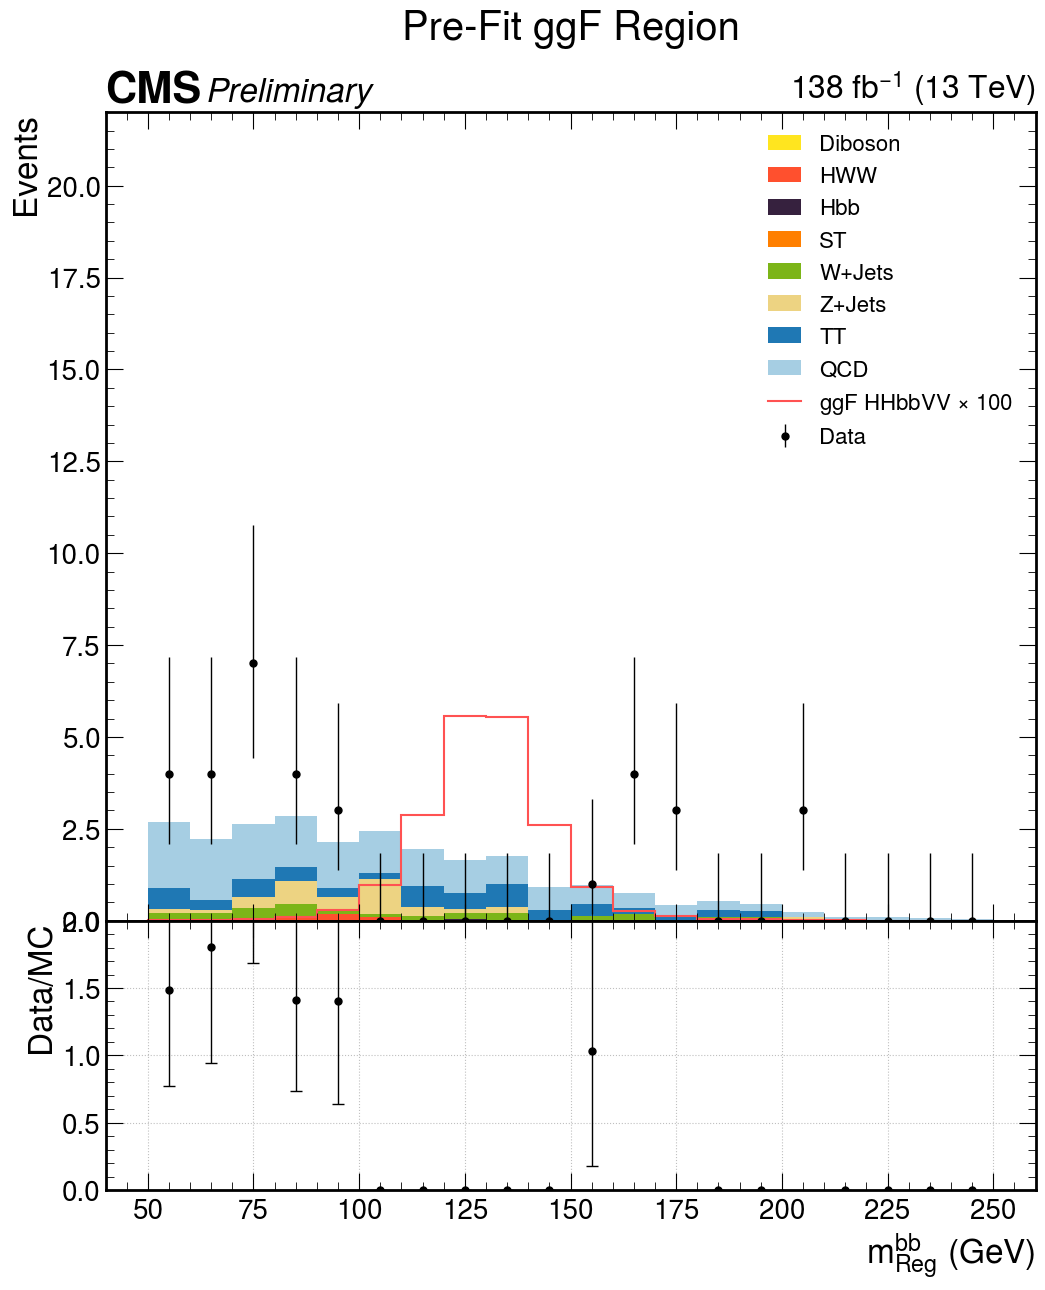

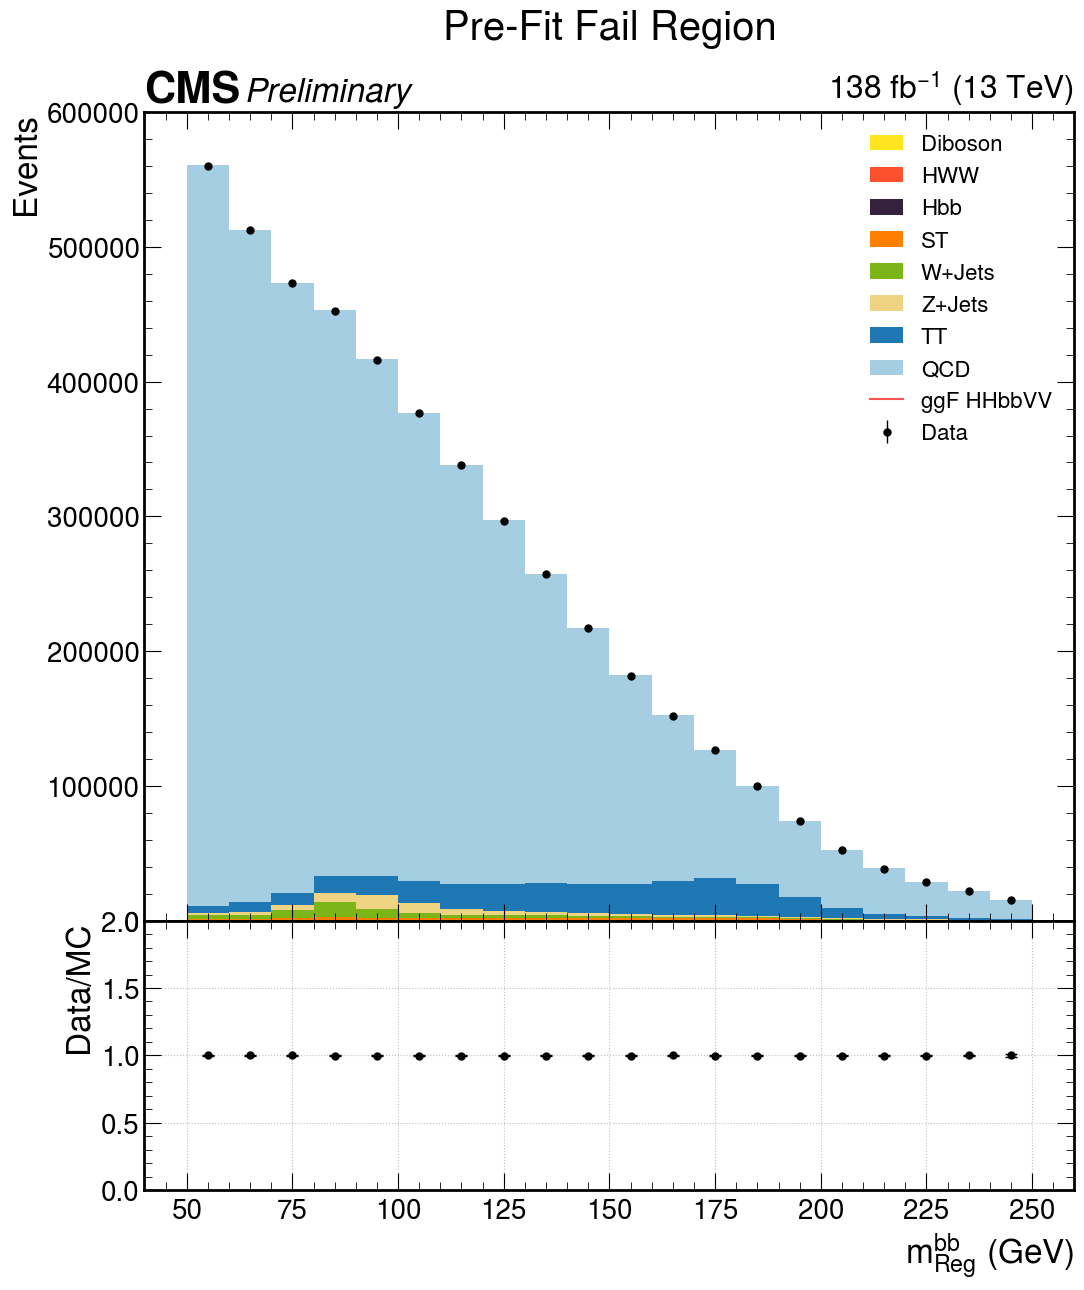

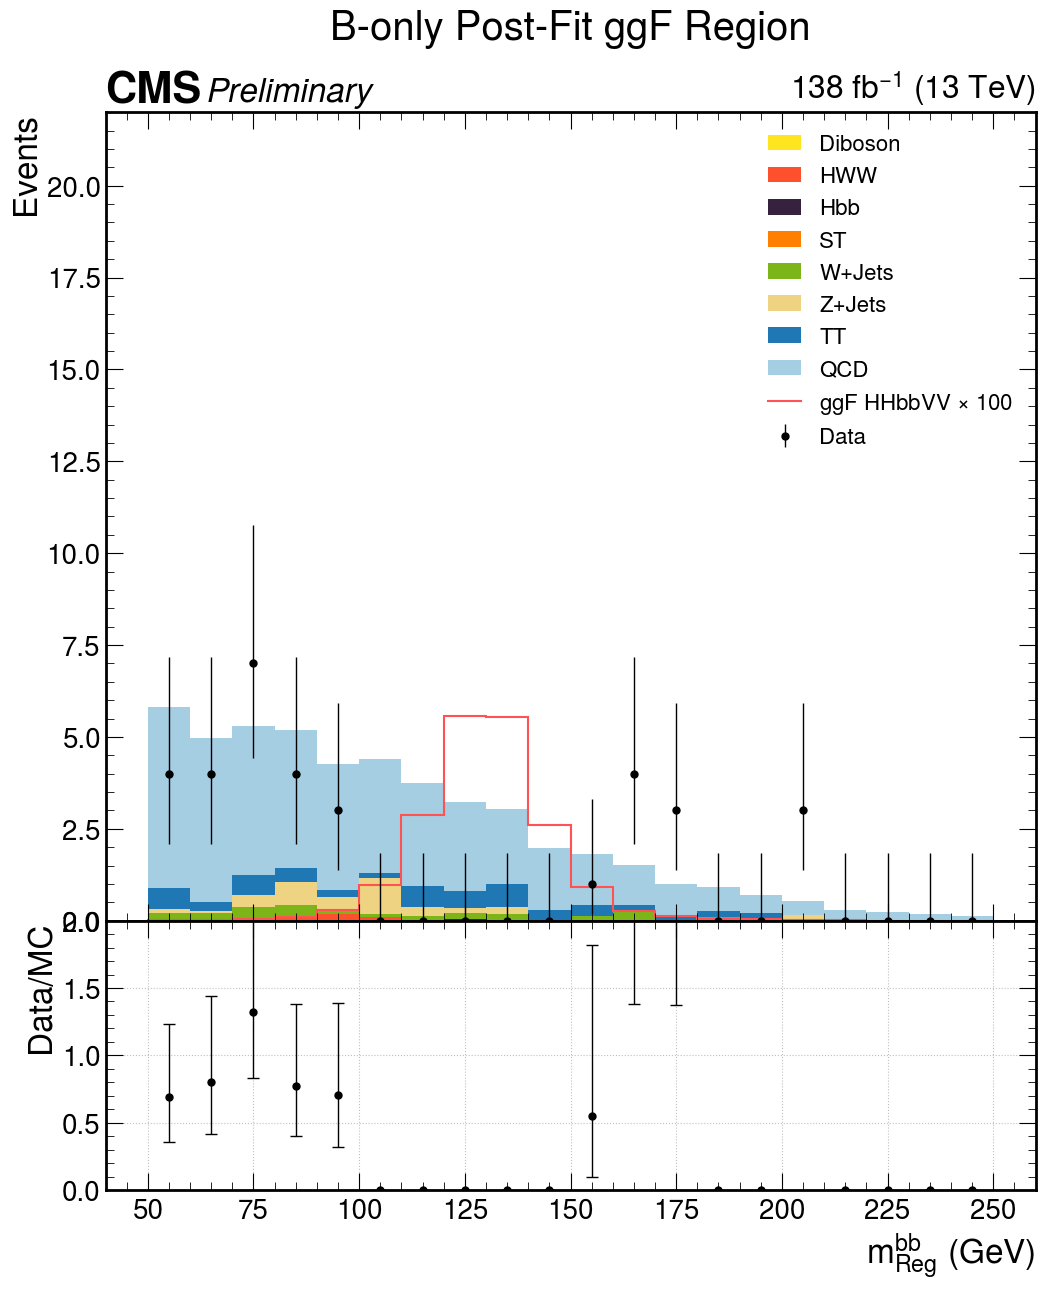

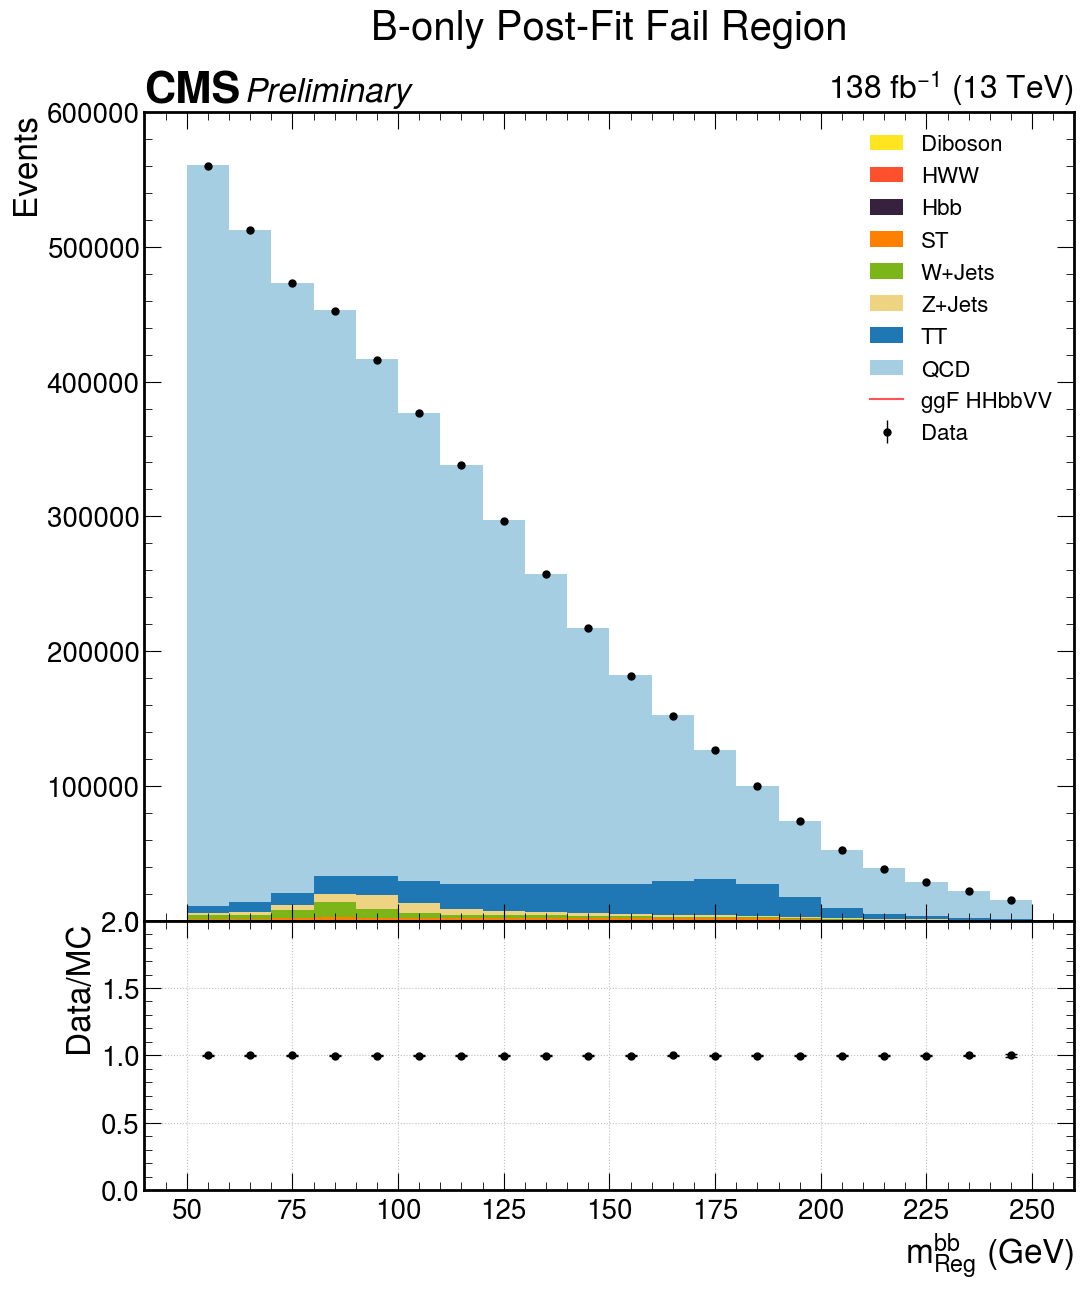

In [47]:
pass_ylim = 8 if vbf else 22
fail_ylim = 600000
title_label = " Asimov Dataset" if asimov else ""
sig_scale_dict = {"HHbbVV": 100, "VBFHHbbVV": 2000, "qqHH_CV_1_C2V_0_kl_1_HHbbVV": 1}
sig_scale_dict = {key: val for key, val in sig_scale_dict.items() if key in sig_keys}

for shape, shape_label in shapes.items():
    for region, region_label in selection_regions.items():
        pass_region = region.startswith("pass")
        for i, shape_var in enumerate(shape_vars):
            plot_params = {
                "hists": hists[shape][region],
                "sig_keys": sig_keys,
                "bg_keys": bg_keys,
                # "bg_err": bgerrs[shape][region],
                "sig_scale_dict": sig_scale_dict if pass_region else None,
                "show": True,
                "year": "all",
                "ylim": pass_ylim if pass_region else fail_ylim,
                "title": f"{shape_label} {region_label} Region{title_label}",
                "name": f"{plot_dir}/{shape}_{region}_{shape_var.var}.pdf",
            }

            plotting.ratioHistPlot(**plot_params, data_err=True)

    #     break
    # break

In [ ]:
hists["postfit"]["pass"]["QCD", ...].values()

In [ ]:
edges = hists["postfit"]["pass"].axes[1].edges
mps = (edges[1:] + edges[:-1]) / 2

In [ ]:
errratio = bgerrs["postfit"]["pass"] / sum(
    [hists["postfit"]["pass"][sample, :] for sample in bg_keys]
)
plt.scatter(mps, errratio)
plt.ylabel("Error / Total")
plt.show()

In [ ]:
sum(hists["postfit"]["pass"])

In [ ]:
sum([hists["postfit"]["pass"][sample, :] for sample in bg_keys])